# New differential expression testing using Bayes Factor



Compare sets of DE genes identified using standard hypothesis testing (t-test) on point estimates of parameters and scVI bayes factor tests. 



### Bayes factor calculation *a la scVI*  and *totalVI*


Hypothesis testing in a Bayesian setting can be done by comparing two hypothesis, $H_0$ (null) and $H_1$ (alternate), and choosing the one with the higher probability given the data $X$. That is, accepting or rejecting $H_0$ by comparing the Bayes Factor to a set threshold value:

$$ \frac{P(H_1 | X)}{P(H_0 | X)}
$$


In [1]:
# system
import sys, os
sys.path.insert(0,'../BIVI/')

# timing
import time

# numbers
import numpy as np
import torch
import pandas as pd

# sc 
import anndata

# plots
import matplotlib.pyplot as plt
import seaborn as sns
cmap = plt.get_cmap('Purples')
cmap_green = plt.get_cmap('Greens')
cmap_orange = plt.get_cmap('Oranges')
cmap_red = plt.get_cmap('Reds')
cmap_blue = plt.get_cmap('Blues')
cmap_ygb = plt.get_cmap('YlGnBu')

# biVI
import biVI
import scvi
print(scvi.__version__)



# reproducibility, set random seeds
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
np.random.seed(8675309)

Global seed set to 0
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


0.18.0


Load in data.

In [2]:
# first load in data
adata = anndata.read_loom('../../data/allen/B08_processed_hv.loom')

# make variable names unique 
adata.var_names_make_unique()

# remove genes with fewer than 10 cells
cell_types = np.array(adata.obs['subclass_label'].tolist())


# ordered according to cell subclass
unique_cell_types = ['Lamp5', 'Sncg', 'Vip', 'Sst', 'Pvalb',
                    'L2/3 IT', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6b',
                    'Astro', 'OPC', 'Oligo', 'Macrophage', 'Endo']


for ct in unique_cell_types:
    
    cells_per_ct_ = (ct == cell_types).sum()
    if cells_per_ct_ < 10.0:
        adata = adata[adata.obs['subclass_label'] != ct, :]
    
adata = adata.copy() 

cell_types = np.array(adata.obs['subclass_label'].tolist())



/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Load in trained models

In [3]:
import importlib
importlib.reload(biVI)

<module 'biVI' from '/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py'>

In [4]:
model1 = biVI.biVI.load("../../results/Bursty_B08_processed_hv_MODEL", adata=adata, use_gpu = True)
model2 = scvi.model.SCVI.load("../../results/scVI_B08_processed_hv_MODEL", adata=adata, use_gpu = True)
# model3 = biVI.biVI.load("../../results/Constitutive_B08_processed_hv_MODEL", adata=adata, use_gpu = True)
# model4 = biVI.biVI.load("../../results/Extrinsic_B08_processed_hv_MODEL", adata=adata, use_gpu = True)

INFO     File ../../results/Bursty_B08_processed_hv_MODEL/model.pt already downloaded                              
{'n_input': 4000, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear
INFO     File ../../results/scVI_B08_processed_hv_MODEL/model.pt already downloaded                                


/home/tara/.local/lib/python3.8/site-packages/scvi/model/base/_utils.py:142: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(
/home/tara/.local/lib/python3.8/site-packages/scvi/model/base/_utils.py:142: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


## Calculate Bayes Factors for one cell type versus rest 

In [6]:
# scVI has a nice built function that allows easy comparisons between cell types
delta = 1.0
scVI_BF_DE_built = model2.differential_expression(adata, groupby = "Cell Type", m_permutation = 10000,
                                           mode = "change", delta = delta, n_samples = 20)

DE...: 100%|██████████| 20/20 [00:02<00:00,  7.43it/s]


In [9]:
# In biVI, for now loop through cell types and calculate BF for each
n_samples = 20
parameters = ['norm_burst_size','norm_degradation_rate','norm_spliced_mean','norm_unspliced_mean']
biVI_BF_DE = {ct : {} for ct in unique_cell_types}
scVI_BF_DE = {ct : {} for ct in unique_cell_types}
const_BF_DE = {ct : {} for ct in unique_cell_types}
ext_BF_DE = {ct : {} for ct in unique_cell_types}

for cell_type in unique_cell_types:
    print(cell_type)
    idx1 = np.arange(len(cell_types))[cell_types == cell_type]
    idx2 =  np.arange(len(cell_types))[cell_types != cell_type]

    biVI_BF_DE[cell_type] = model1.get_bayes_factors(adata,idx1,idx2,
                                                     n_samples_1 = n_samples,
                                                     n_samples_2 = n_samples,
                                                     n_comparisons = 10000,
                                                     return_df = True,
                                                     delta = delta)
    
    
#     params1 = model2.get_normalized_expression(adata[idx1],
#                                           n_samples = n_samples, return_mean = False)
#     params2 = model2.get_normalized_expression(adata[idx2],
#                                           n_samples = n_samples, return_mean = False)
#     params_dict_1 = {}
#     params_dict_2 = {}
#     params_dict_1['norm_unspliced_mean'] = params1[:,:,:2000]
#     params_dict_1['norm_spliced_mean'] = params1[:,:,2000:]
#     params_dict_2['norm_unspliced_mean'] = params2[:,:,:2000]
#     params_dict_2['norm_spliced_mean'] = params2[:,:,2000:]
    
#     scVI_BF_DE[cell_type] = model1.get_bayes_factors(adata,idx1,idx2,
#                                                      n_samples_1 = n_samples,
#                                                      n_samples_2 = n_samples,
#                                                      n_comparisons = 10000,
#                                                      return_df = True,
#                                                      delta = delta,
#                                                     params_dict_1 = params_dict_1,
#                                                     params_dict_2 = params_dict_2)
    
#     params1c = model3.get_normalized_expression(adata[idx1],
#                                           n_samples = n_samples, return_mean = False)
#     params2c = model3.get_normalized_expression(adata[idx2],
#                                           n_samples = n_samples, return_mean = False)

#     const_BF_DE[cell_type] = model3.get_bayes_factors(adata,idx1,idx2,
#                                                      n_samples_1 = n_samples,
#                                                      n_samples_2 = n_samples,
#                                                      n_comparisons = 10000,
#                                                      return_df = True,
#                                                      delta = 1.0)
    
#     ext_BF_DE[cell_type] = model3.get_bayes_factors(adata,idx1,idx2,
#                                                      n_samples_1 = n_samples,
#                                                      n_samples_2 = n_samples,
#                                                      n_comparisons = 10000,
#                                                      return_df = True,
#                                                      delta = 1.0)

Lamp5
Sncg
Vip
Sst
Pvalb
L2/3 IT
L5 IT
L5/6 NP


/home/tara/maria/scBIVI/GCCCP_2021/Code/Preprint/../BIVI/biVI.py:529: RuntimeWarning: divide by zero encountered in true_divide
  BF = np.sum(lfc_abs>=delta,axis=0)/(np.sum(lfc_abs<delta,axis=0))


L6 CT
L6 IT
L6b
Astro
OPC
Oligo
Macrophage
Endo


Get significant genes using Bayes Factor for scVI and biVI.

The scVI paper uses a Bayes Factor cutoff of 0.7 and a delta cutoff of 0.25 (although this seems too small to me, perhaps I will use a more stringent cutoff).


The delta cutoff means that absolute value log2(param_in_A/param_in_rest) >= delta.

The Bayes Factor is the probability that log2(param_in_A/param_in_rest) >= delta divided by the probability that it is less than delta. 


In [10]:
genes_unspliced = adata.var['gene_name'].tolist()
genes_unspliced[2000:] = [0]*2000
genes_spliced = adata.var['gene_name'].tolist()
genes_spliced[:2000] = [0]*2000
genes = np.array(adata.var['gene_name'])[:2000]

In [11]:
biVI_sig_BF_genes = {ct : {} for ct in unique_cell_types}
# scVI_sig_BF_genes = {ct : {} for ct in unique_cell_types}
# const_sig_BF_genes = {ct : {} for ct in unique_cell_types}
# ext_sig_BF_genes = {ct : {} for ct in unique_cell_types}

scVI_sig_BF_genes_built = {ct : {} for ct in unique_cell_types}

BF_THRESH = 1.5
LFC_THRESH = 1.0


for cell_type in unique_cell_types:
    print(cell_type)
    idx_scVI = np.array(scVI_BF_DE_built[(scVI_BF_DE_built['group1']==cell_type) & 
                                         (scVI_BF_DE_built['bayes_factor']>BF_THRESH) &
                                         (scVI_BF_DE_built['lfc_mean']>LFC_THRESH)].index,dtype=int)

    sig_genes_unspliced = list(map(genes_unspliced.__getitem__,idx_scVI))
    sig_genes_unspliced = [g for g in sig_genes_unspliced if g != 0]
    
    sig_genes_spliced = list(map(genes_spliced.__getitem__,idx_scVI))
    sig_genes_spliced = [g for g in sig_genes_spliced if g != 0]
    
    
    scVI_sig_BF_genes_built[cell_type]['norm_unspliced_mean'] = sig_genes_unspliced
    scVI_sig_BF_genes_built[cell_type]['norm_spliced_mean'] = sig_genes_spliced
    
    for param in biVI_BF_DE[cell_type].keys():
        
        df = biVI_BF_DE[cell_type][param]
        
        idx_biVI = np.array(df[(np.log(df['bayes_factor'])>BF_THRESH) &
                                (np.log(df['lfc_mean'])>LFC_THRESH)].index,dtype=int)
        sig_genes_param = list(map(genes.__getitem__,idx_biVI))
        biVI_sig_BF_genes[cell_type][param] = sig_genes_param
        
#     for param in scVI_BF_DE[cell_type].keys():
#         df = scVI_BF_DE[cell_type][param]
        
#         idx_scVI = np.array(df[np.log(df['bayes_factor'])>BF_THRESH].index,dtype=int)
#         sig_genes_param = list(map(genes.__getitem__,idx_scVI))
        
#         scVI_sig_BF_genes[cell_type][param] = sig_genes_param

#     for param in const_BF_DE[cell_type].keys():
#         df = const_BF_DE[cell_type][param]
        
#         idx_const = np.array(df[np.log(df['bayes_factor'])>BF_THRESH].index,dtype=int)
#         sig_genes_param = list(map(genes.__getitem__,idx_const))
        
#         const_sig_BF_genes[cell_type][param] = sig_genes_param
        
#     for param in ext_BF_DE[cell_type].keys():
#         df = ext_BF_DE[cell_type][param]
        
#         idx_ext = np.array(df[np.log(df['bayes_factor'])>BF_THRESH].index,dtype=int)
#         sig_genes_param = list(map(genes.__getitem__,idx_ext))
        
#         ext_sig_BF_genes[cell_type][param] = sig_genes_param
        

Lamp5
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
Sncg
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
Vip
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
Sst
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
Pvalb
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
L2/3 IT
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
L5 IT
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
L5/6 NP
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
L6 CT
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
L6 IT
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
L6b
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
Astro
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
OPC
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
Oligo
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
Macrophage
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
Endo
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM
BIVI PARAM


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [86]:
for ct in unique_cell_types[:3]:

    print('Working cell type: ',ct)

    for param in biVI_sig_BF_genes[ct].keys():
        n = len(biVI_sig_BF_genes[ct][param])
        print(f'There are {n} genes significant in {param} BIVI MINE')
        
    for param in scVI_sig_BF_genes_built[ct].keys():
        n = len(scVI_sig_BF_genes_built[ct][param])
        print(f'There are {n} genes significant in {param} SCVI BUILT')
        
    for param in scVI_sig_BF_genes[ct].keys():
        n = len(scVI_sig_BF_genes[ct][param])
        print(f'There are {n} genes significant in {param} SCVI MINE')

        
#     for param in const_sig_BF_genes[ct].keys():

#         n = len(const_sig_BF_genes[ct][param])
#         print(f'There are {n} genes significant in {param} const')
        
#     for param in ext_sig_BF_genes[ct].keys():

#         n = len(ext_sig_BF_genes[ct][param])
#         print(f'There are {n} genes significant in {param} ext')

Working cell type:  Lamp5
asdasda
There are 144 genes significant in norm_burst_size BIVI MINE
asdasda
There are 180 genes significant in norm_degradation_rate BIVI MINE
asdasda
There are 0 genes significant in norm_splicing_rate BIVI MINE
asdasda
There are 123 genes significant in norm_spliced_mean BIVI MINE
asdasda
There are 125 genes significant in norm_unspliced_mean BIVI MINE
There are 1 genes significant in norm_unspliced_mean SCVI BUILT
There are 3 genes significant in norm_spliced_mean SCVI BUILT
There are 0 genes significant in norm_unspliced_mean SCVI MINE
There are 0 genes significant in norm_spliced_mean SCVI MINE
Working cell type:  Sncg
There are 5 genes significant in norm_unspliced_mean SCVI BUILT
There are 16 genes significant in norm_spliced_mean SCVI BUILT
Working cell type:  Vip
There are 2 genes significant in norm_unspliced_mean SCVI BUILT
There are 7 genes significant in norm_spliced_mean SCVI BUILT


# Novel gene identification

Identify genes that are DE (up, for now) in biVI parameters but NOT in scVI spliced means (as is the typical case).




In [12]:
b_changed_mu2_unchanged = {}
gamma_changed_mu2_unchanged = {}

for ct in unique_cell_types:
    genes_b = biVI_sig_BF_genes[cell_type]['norm_burst_size']
    genes_gamma = biVI_sig_BF_genes[cell_type]['norm_degradation_rate']
    genes_scVI_mu2 = scVI_sig_BF_genes_built[cell_type]['norm_spliced_mean']
    
    b_changed_mu2_unchanged[ct] = [g for g in genes_b if g not in genes_scVI_mu2]
    gamma_changed_mu2_unchanged[ct] = [g for g in genes_gamma if g not in genes_scVI_mu2]

In [13]:
'Ndnf' in b_changed_mu2_unchanged['L6 CT']

True

In [14]:
'Trem2' in gamma_changed_mu2_unchanged['L5 IT']

True

------

# Plot biVI DE genes

<ipython-input-22-5adba29b9aa7>:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  biVIX_sig_genes = [g for g in biVI_sig_genes if g not in mu_sig_genes]
<ipython-input-22-5adba29b9aa7>:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  both_sig_genes = [g for g in biVI_sig_genes if g in mu_sig_genes]


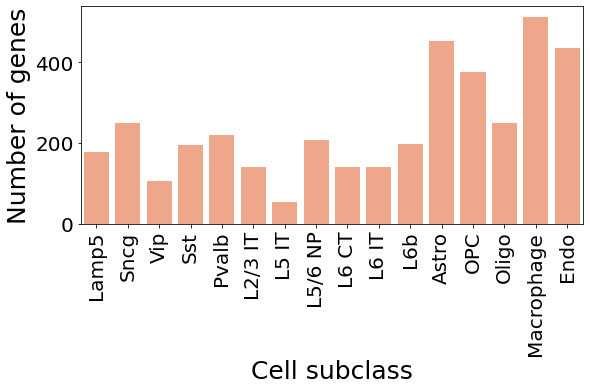

In [22]:
sig_gene_plot = []

num_muX_sig = 0
num_both_sig = 0
num_biVIX_sig = 0

for ct in unique_cell_types:

    biVI_sig_genes = np.array(biVI_sig_BF_genes[ct]['norm_burst_size'] + biVI_sig_BF_genes[ct]['norm_degradation_rate'])
    
    biVI_sig_genes = np.unique(biVI_sig_genes)

    mu_sig_genes = np.array(scVI_sig_BF_genes_built[ct]['norm_spliced_mean'])
                           # + scVI_sig_BF_genes_built[ct]['norm_unspliced_mean'])
    mu_sig_genes = np.unique(mu_sig_genes)
    muX_sig_genes = [g for g in mu_sig_genes if g not in biVI_sig_genes]
    
    biVIX_sig_genes = [g for g in biVI_sig_genes if g not in mu_sig_genes]
    
    both_sig_genes = [g for g in biVI_sig_genes if g in mu_sig_genes]
    sig_gene_plot.append(len(biVIX_sig_genes))
    
    num_muX_sig += len(muX_sig_genes)
    num_both_sig += len(both_sig_genes)
    num_biVIX_sig += len(biVIX_sig_genes)
        
plt.figure(figsize=(9,4))
sns.barplot(x =  unique_cell_types, y = sig_gene_plot,
            palette = ['lightsalmon' for i in range(19)])

plt.xticks(rotation=90);
plt.xlabel('Cell subclass',fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=20)
#plt.title(f'$biVI$ Significant Differentially Regulated Genes',fontsize = 30)
plt.ylabel('Number of genes',fontsize = 25);



plt.savefig(f'../../results/B08_processed_hv_figs/biVI_DE_genes.png',bbox_inches='tight')




In [23]:
print(num_muX_sig)
print(num_both_sig)
print(num_biVIX_sig)

0
0
3865


# Fraction of DE genes


For all genes found to be differentially expressed in *biVI* parameters, are they mostly regulated by burst size, degradation rate, or both?

In [24]:
compare_b_gamma_dict = {ct : {} for ct in unique_cell_types}

b_fractions = []
gamma_fractions = []
both_fractions = []
ct_for_df = []

for ct in unique_cell_types:
        print(ct)
        b_genes = biVI_sig_BF_genes[ct]['norm_burst_size']
        gamma_genes = biVI_sig_BF_genes[ct]['norm_degradation_rate']
        
        
        all_sig_genes = np.unique( np.array(b_genes+gamma_genes) )
        
        if len(all_sig_genes) != 0: 
            fraction_b_genes = len([b for b in b_genes if b not in gamma_genes])/len(all_sig_genes)
            fraction_gamma_genes = len([g for g in gamma_genes if g not in b_genes])/len(all_sig_genes)
            fraction_both = len([a for a in all_sig_genes if (a in b_genes) and (a in gamma_genes)])/len(all_sig_genes)
        
        
            b_fractions.append(fraction_b_genes) 
            gamma_fractions.append(fraction_gamma_genes) 
            both_fractions.append(fraction_both)
            ct_for_df.append(ct)
        
        

Lamp5
Sncg
Vip
Sst
Pvalb
L2/3 IT
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Astro
OPC
Oligo
Macrophage
Endo


In [18]:
# how many genes

In [19]:

N = len(ct_for_df)
df_1 = pd.DataFrame({'Cell subclass' : ct_for_df,'Fraction' : b_fractions, 'Parameter' : ['Burst size']*N})
df_2 = pd.DataFrame({'Cell subclass' : ct_for_df,'Fraction' : gamma_fractions, 'Parameter' : ['Relative degradation rate']*N})
df_3 = pd.DataFrame({'Cell subclass' : ct_for_df,'Fraction' : both_fractions, 'Parameter' : ['Both']*N})
df_plot = pd.concat([df_1,df_2,df_3],axis=0)

In [20]:
# get number of cells in each cell type
num_cell_type = []
for ct in ct_for_df:
    num_cell_type.append(len(adata[adata.obs.subclass_label==ct]))

<ipython-input-25-c8b49c45f923>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0,],fontsize = 30)
<ipython-input-25-c8b49c45f923>:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1].set_ylim(0,8000)
<ipython-input-25-c8b49c45f923>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([0,1,10,10**2,10**3],fontsize = 25);


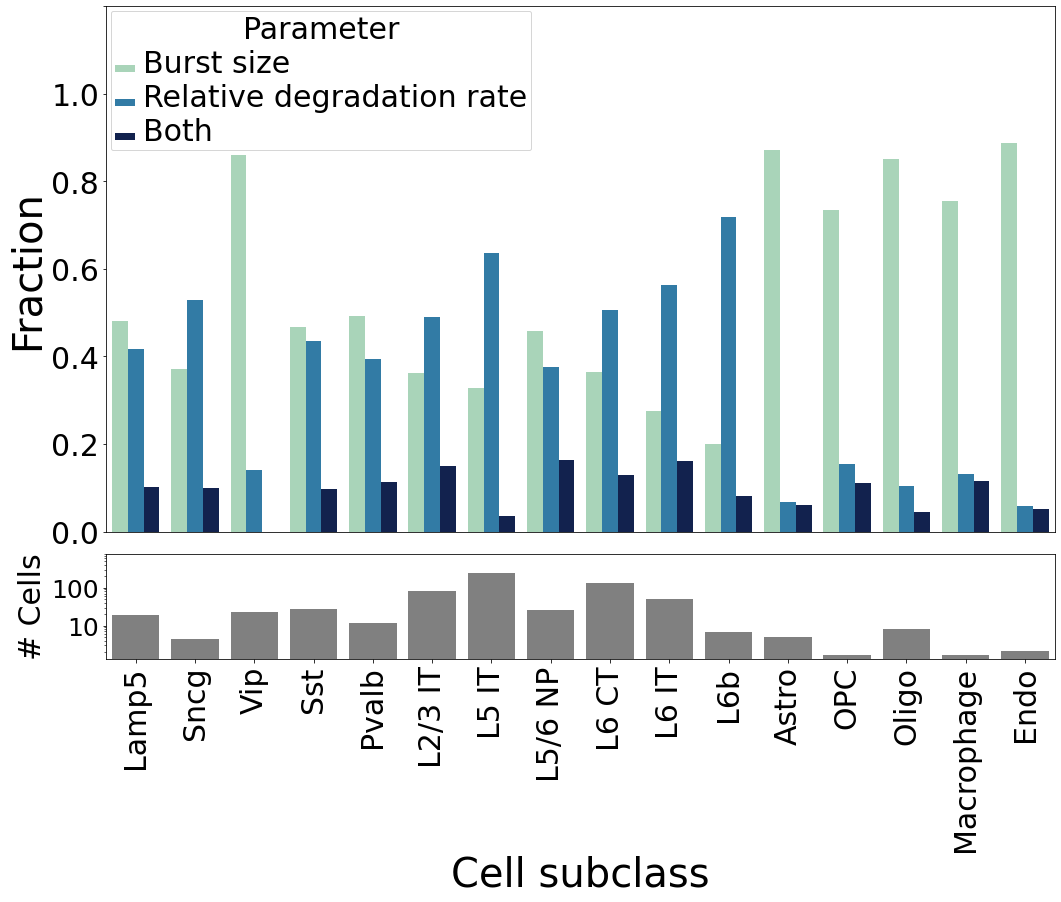

In [25]:
fig, ax = plt.subplots(2,1,figsize = (17,12),gridspec_kw={'height_ratios': [5, 1],
                                                         'wspace': 0.0, 'hspace':0.07})
plt.xticks(rotation = 90, fontsize = 30)
fig.subplots_adjust(wspace=None)
#plt.yticks(fontsize=34)
sns.barplot(x='Cell subclass', y='Fraction', hue='Parameter', data=df_plot, 
            palette = [cmap_ygb(80),cmap_ygb(170),cmap_ygb(270)], ax = ax[0])
ax[0].set_ylabel('Fraction',fontsize = 40)
ax[0].set_ylim(0,1.2)
ax[0].set(xlabel=None)
ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,)
ax[0].set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0,],fontsize = 30)
plt.setp(ax[0].get_legend().get_texts(), fontsize='30');
plt.setp(ax[0].get_legend().get_title(), fontsize='30');


sns.barplot(x=ct_for_df,y = num_cell_type,color = 'gray',ax=ax[1])
ax[1].set_xticklabels(ct_for_df, rotation=90);
ax[1].set_yscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Cell subclass',fontsize = 40)
ax[1].set_ylabel('# Cells',fontsize = 30)
ax[1].set_ylim(0,8000)
ax[1].set_yticklabels([0,1,10,10**2,10**3],fontsize = 25);
#ax[1].ticklabel_format(axis='y',style='sci');


plt.savefig(f'../../results/B08_processed_hv_figs/b_gamma_percent.png',bbox_inches='tight');